# WMT of tendency terms
## CM2.6
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

In [20]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [21]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.3e606d69f77b4623812ed7c20c2d8af7/status,


In [41]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated

In [2]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [45]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tendencies.zarr'))
#drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/drhodts_tendencies.zarr'))
cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr'))
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap.zarr'))

tendencies = xr.merge([tracers, cab, rho])

In [46]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    SSS_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SST_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [47]:
res = tendencies.rho_lap + tendencies.cabbeling - tendencies.SSS_lap - tendencies.SST_lap

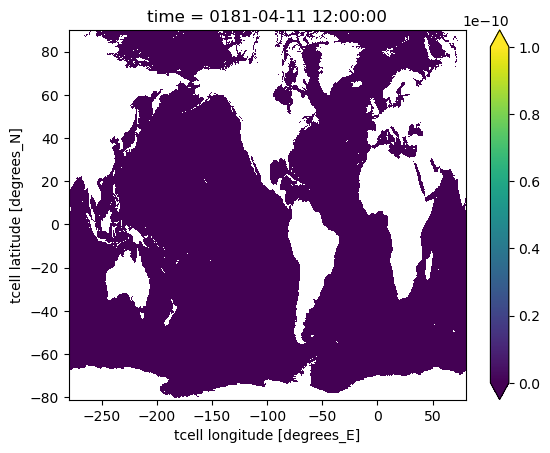

In [48]:
res.isel(time=100).plot(robust=True, vmin=1e-10);

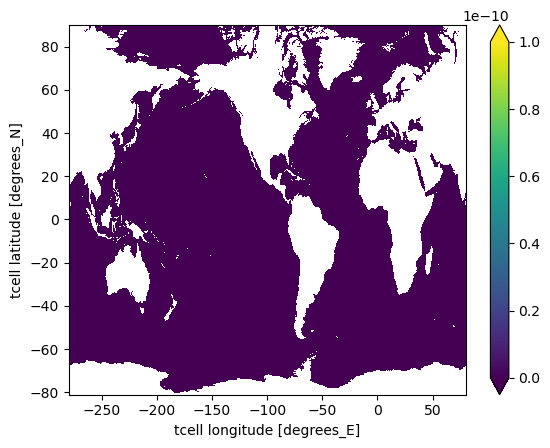

In [49]:
res.mean('time').plot(robust=True, vmin=1e-10);

In [9]:
def open_surf_tends(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf/' + basin_file + '_tends.zarr'))
    return ds

In [16]:
def open_histograms(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/' + 
                                              basin_file + '.zarr'))
    return ds

In [11]:
surf_names = list(['natl_ocean_surf', 'satl_ocean_surf', 'npac_ocean_surf', 
                   'spac_ocean_surf', 'arc_ocean_surf', 'south_ocean_surf', 'ind_ocean_surf'])
surf_hist_names = list(['natl_hist_surf', 'satl_hist_surf', 'npac_hist_surf', 
                   'spac_hist_surf', 'arc_hist_surf', 'south_hist_surf', 'ind_hist_surf'])
hist_names = list(['natl_hist', 'satl_hist', 'npac_hist', 
             'spac_hist', 'arc_hist', 'south_hist', 'ind_hist'])
surf_tends = list()
surf_hist = list()
hist = list()

In [12]:
#load in basin surface tendencies
for name in surf_names:
    surf_tends.append(open_surf_tends(name))
    for ds in surf_tends:
        globals()[name] = ds

In [17]:
#load in basin surface histograms
for name in surf_hist_names:
    surf_hist.append(open_histograms(name))
    for ds in surf_hist:
        globals()[name] = ds

In [18]:
#load in basin mixing histograms
for name in hist_names:
    hist.append(open_histograms(name))
    for ds in hist:
        globals()[name] = ds

In [19]:
natl_hist

<xarray.Dataset>
Dimensions:          (time: 240, rho0_bin: 199)
Coordinates:
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
  * time             (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
Data variables:
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

# Plot ann mean

In [52]:
residual = ((natl_hist.OMEGA_rho_lap - natl_hist.OMEGA_sss - 
             natl_hist.OMEGA_sst + natl_hist.OMEGA_cabbeling)/1e6).mean('time')

In [54]:
def ann_mean2(ds):
    fig = plt.figure(figsize=(12,5))
    line_colors=['blue', 'k', 'orange', 
                 'green'] #order of cab, rho, sss, sst
    for (i,j) in zip(list(ds.data_vars), line_colors):
        (ds[i].mean('time')/1e6).plot(label=f'{i}', color=j)
        residual.plot(color='grey', linestyle='dashed')
    plt.legend()
    #plt.ylim(-20,10)
    plt.ylabel(r'Transformation (Sv)', fontsize=16)
    plt.grid()
    plt.title('Annual Mean Transformation Terms', fontsize=20);

In [32]:
natl_hist

<xarray.Dataset>
Dimensions:          (time: 240, rho0_bin: 199)
Coordinates:
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
  * time             (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
Data variables:
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

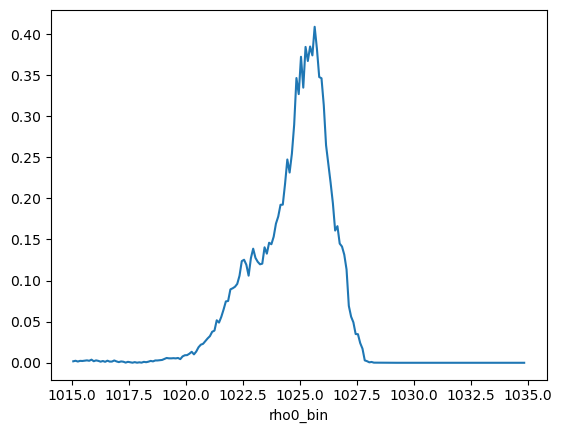

In [53]:
#residual comes from histogram function, tendencies yield 0 residual values
residual.plot()

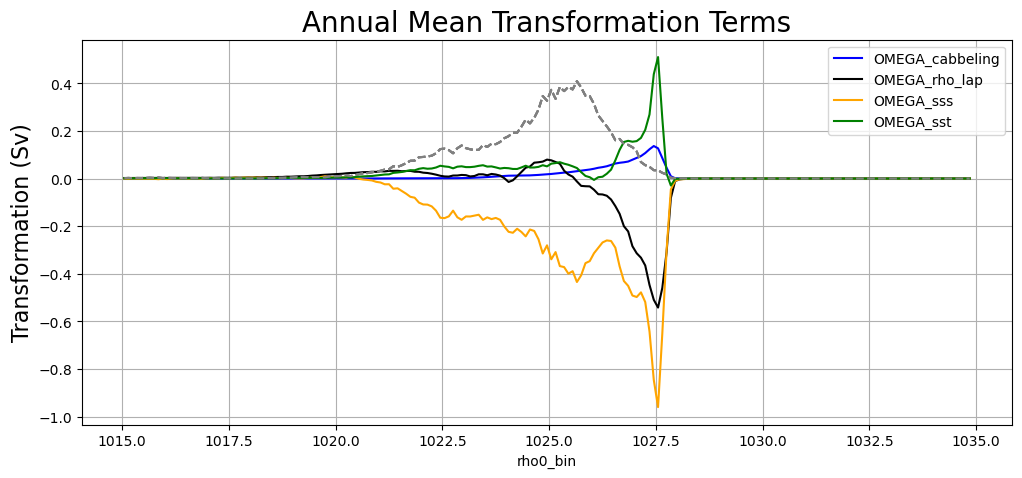

In [55]:
ann_mean2(natl_hist)

In [36]:
natl_hist

<xarray.Dataset>
Dimensions:          (time: 240, rho0_bin: 199)
Coordinates:
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
  * time             (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
Data variables:
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [59]:
def ann_mean(mix, surf):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_colors=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    for (i,j) in zip(list(mix.data_vars), line_colors):
        (mix[i].mean('time')/1e6).plot(label=f'{i}', color=j, ax=ax0)
    
    #plotting mixing residual
    ((mix.OMEGA_rho_lap + mix.OMEGA_cabbeling -
      mix.OMEGA_sss - mix.OMEGA_sst).mean('time')/1e6).plot(label='residual', color='grey', 
                                                                linestyle='dashed', ax=ax0)
    for (i,j) in zip(list(surf.data_vars), line_surf):
        (surf[i].mean('time')/1e6).plot(label=f'{i}', color=j, ax=ax1)
    ax0.legend()
    ax0.set_xlim(1016,1030)
    ax0.set_ylabel(r'Transformation (Sv)', fontsize=16)
    ax0.grid()
    ax0.set_title('Mixing terms')
    ax0.set_xlabel('')
    
    ax1.legend()
    ax1.set_xlim(1016,1030)
    ax1.set_ylabel('')
    ax1.grid()
    ax1.set_title('Surface terms')
    ax1.set_xlabel('')
    
    fig.supxlabel('Rho bins', fontsize=16)
    plt.suptitle('Annual Mean Transformation', fontsize=20);

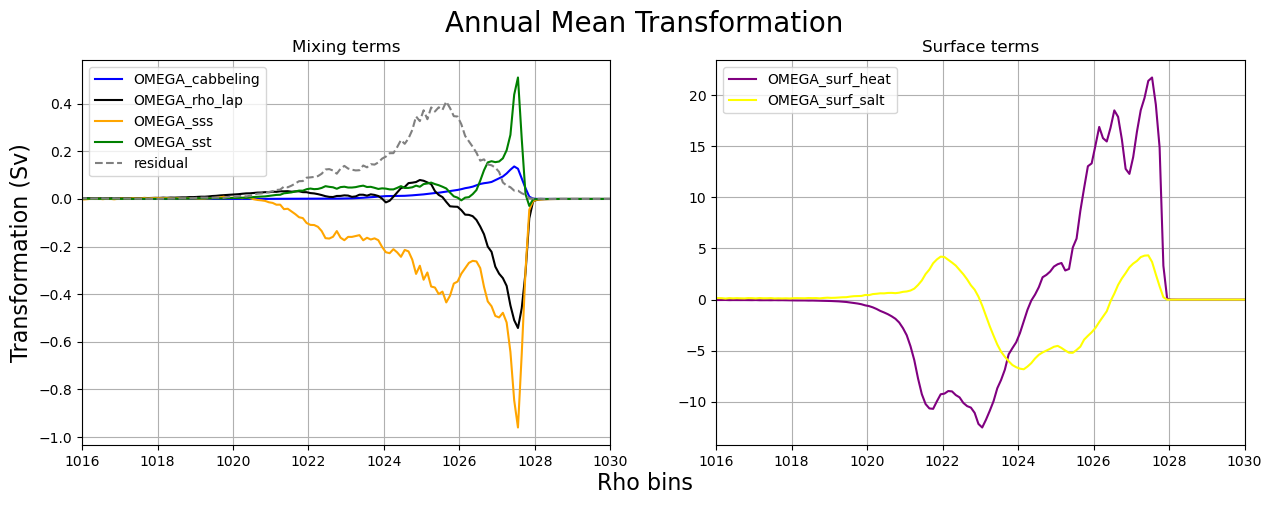

In [60]:
ann_mean(natl_hist, natl_hist_surf)

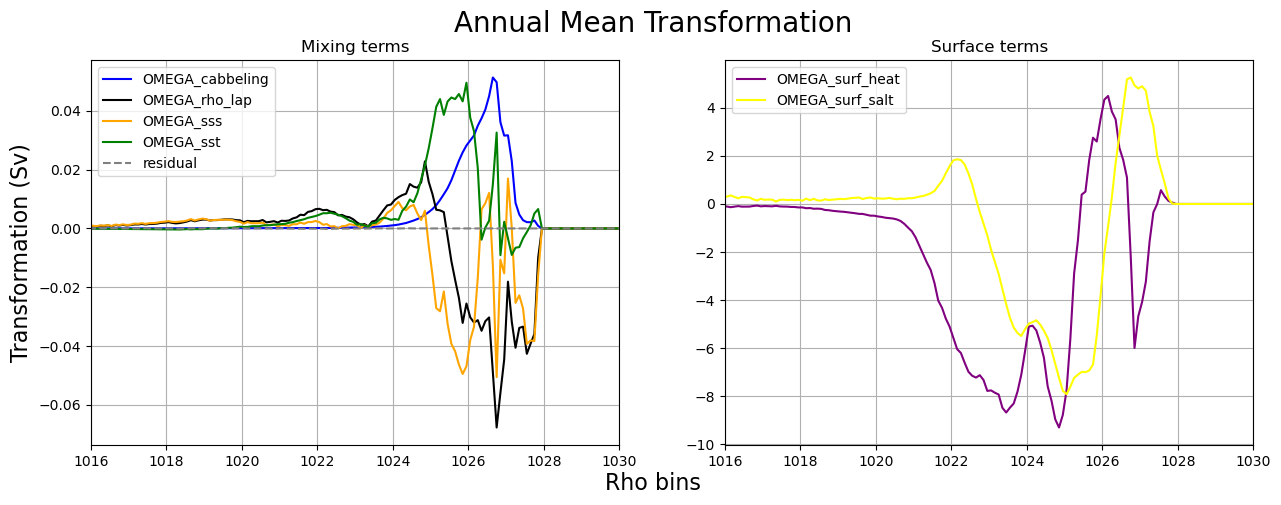

In [62]:
ann_mean(satl_hist, satl_hist_surf)

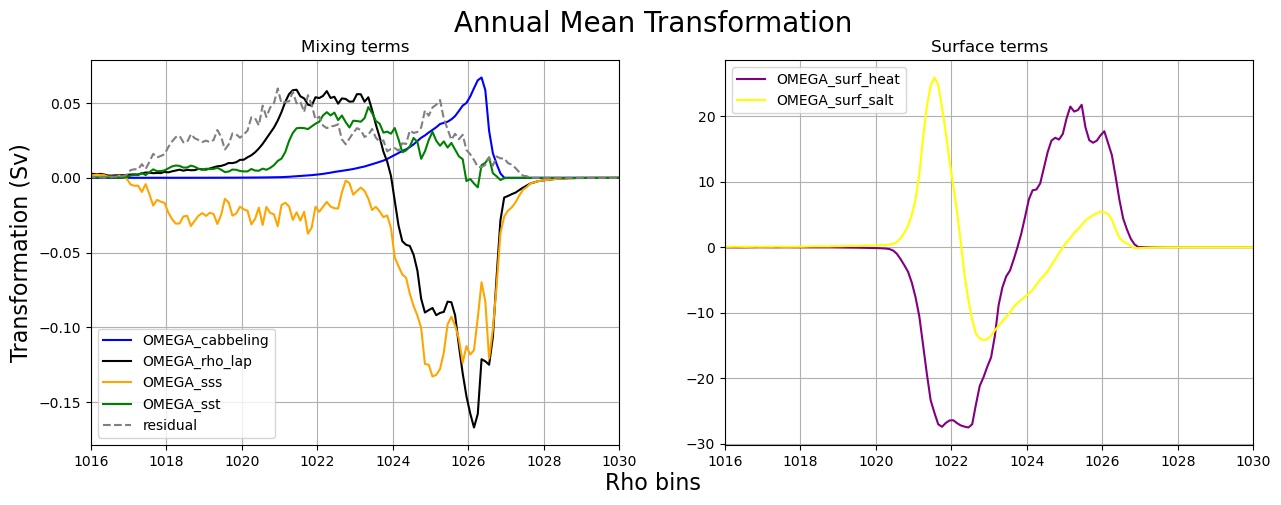

In [63]:
ann_mean(npac_hist, npac_hist_surf)

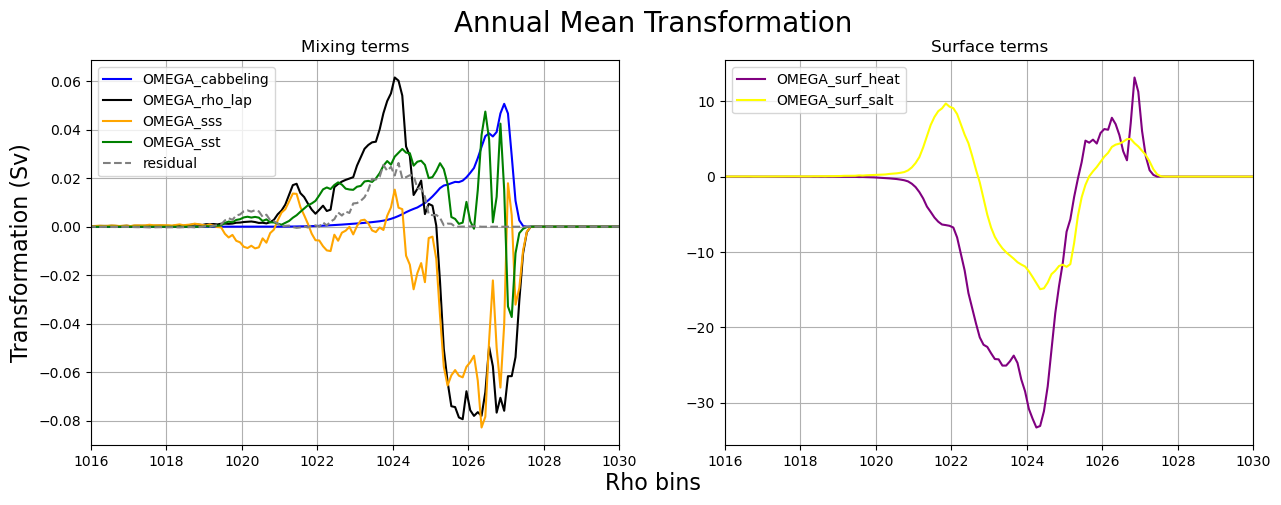

In [64]:
ann_mean(spac_hist, spac_hist_surf)

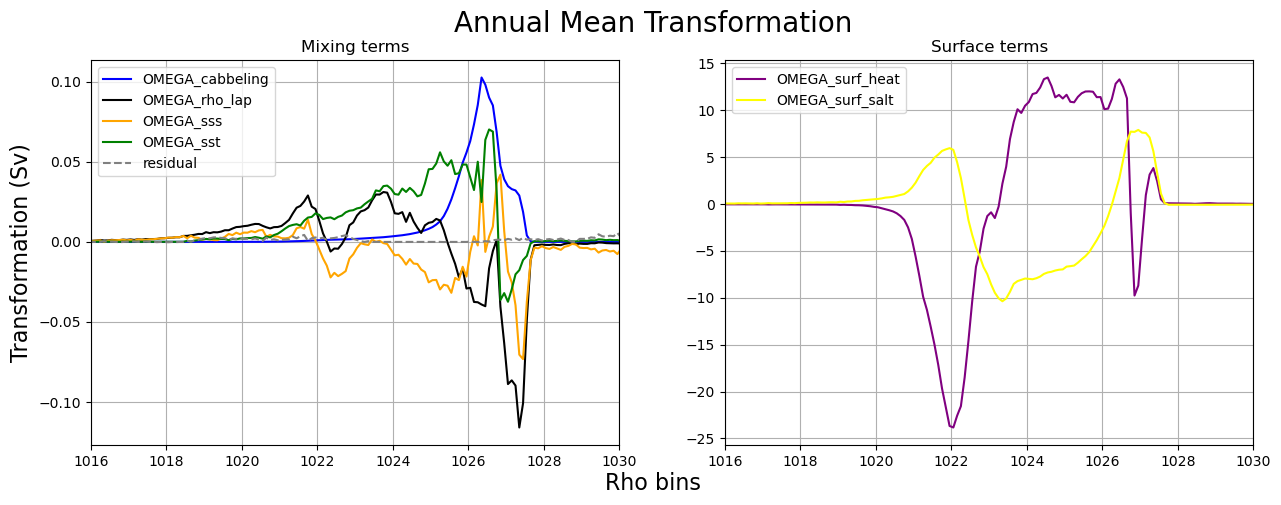

In [65]:
ann_mean(ind_hist, ind_hist_surf)

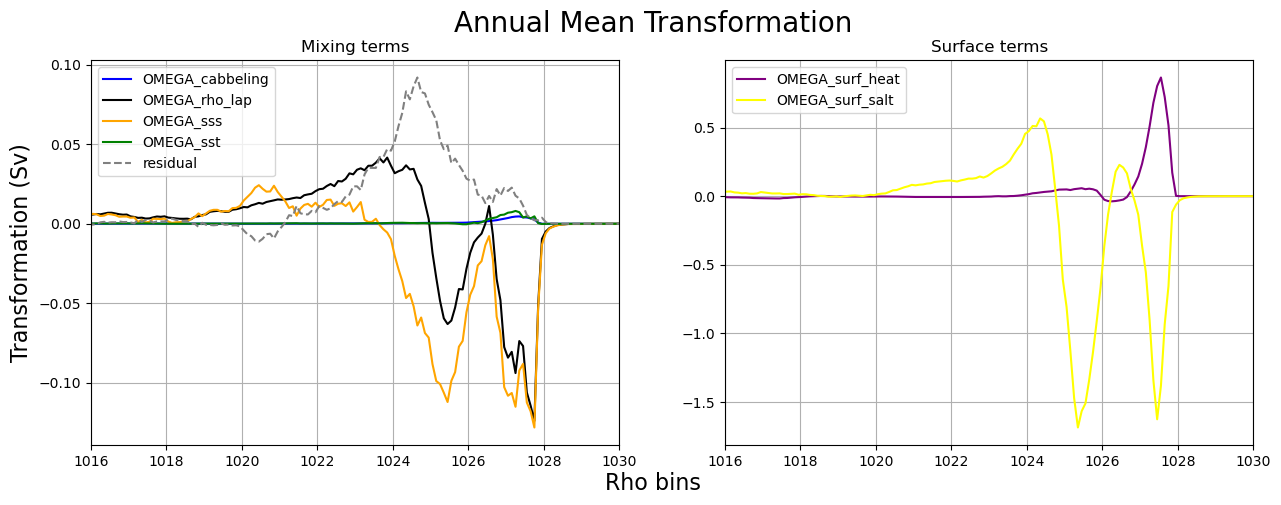

In [66]:
ann_mean(arc_hist, arc_hist_surf)

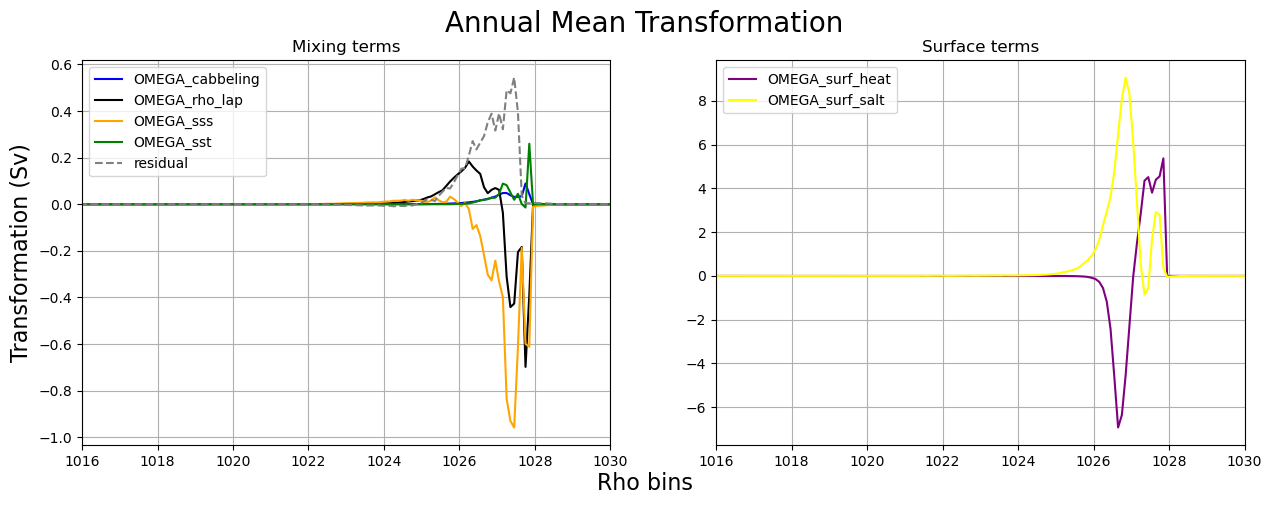

In [67]:
ann_mean(south_hist, south_hist_surf)

[Back to top](#top)